In [76]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [77]:
# 文件的路径
sample_path = "~/Desktop/Cases_1/苏州工业园/Electric power load data/2019/1_hour/2019_1hour_Commercial/20190101_1hour_Commercial.xlsx"
sample_path = os.path.expanduser(sample_path)

# 读取文件头部几行
df = pd.read_excel(sample_path)
print("列名如下：")
print(df.columns)

# 设置文件夹路径
folder_path = os.path.expanduser("~/Desktop/Cases_1/苏州工业园/Electric power load data/2019/1_hour/2019_1hour_Commercial")

# 获取所有 .xlsx 文件
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])

# 创建空 DataFrame 用于合并
combined_df = pd.DataFrame()

列名如下：
Index(['Time', 'Power (kW)'], dtype='object')


In [78]:
# 遍历每个文件
for filename in file_list:
    try:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_excel(file_path, engine='openpyxl')  # 显式指定 engine
        
        # 标准化列名
        df.columns = [col.strip().replace('\n', '').replace('\r', '').lower() for col in df.columns]
        #  print(f"✔ 读取 {filename} 的列名为：{df.columns.tolist()}")
        
        # 判断列名是否存在
        if 'time' in df.columns and 'power (kw)' in df.columns:
            df = df[['time', 'power (kw)']]
            df['SourceFileDate'] = filename[:8]
            
            # 转换类型
            df['time'] = pd.to_datetime(df['time'])
            df['SourceFileDate'] = pd.to_datetime(df['SourceFileDate'])
            
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            raise ValueError("列名不符合预期：'time' 和 'power (kw)' 不存在")
    
    except Exception as e:
        print(f"跳过文件 {filename}, 原因: {e}")


# 保存最终合并的 CSV
combined_df.to_csv("2019_1hour_long_commercial.csv", index=False)
print("成功导出为 '2019_1hour_long_commercial.csv'")

成功导出为 '2019_1hour_long_commercial.csv'


In [79]:
df = pd.read_csv("2019_1hour_long_commercial.csv", encoding='utf-8-sig')
df.columns = [col.strip().lower() for col in df.columns]  # 统一小写 + 去空格

# 统一时间格式
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.time

# 去重，只保留第一条记录
df = df.drop_duplicates(subset=['date', 'hour'], keep='first')

# 生成每天一行，每小时一列的负载矩阵
pivot_df = df.pivot(index='date', columns='hour', values='power (kw)').reset_index()
pivot_df.to_csv("daily_load_matrix.csv", index=False)

print("已成功生成 daily_load_matrix.csv（重复已处理）")

已成功生成 daily_load_matrix.csv（重复已处理）


In [80]:
pivot_df = pd.read_csv("daily_load_matrix.csv")
# 插值 + 双向填充
pivot_df_interp = pivot_df.set_index('date')
pivot_df_interp = pivot_df_interp.interpolate(axis=1, limit_direction='both')
pivot_df_interp = pivot_df_interp.ffill(axis=1).bfill(axis=1)

# 丢掉真的没救的数据（全为空行）
pivot_df_interp = pivot_df_interp.dropna(thresh=10)  # 至少保留10小时数据
pivot_df_interp = pivot_df_interp.reset_index()

In [81]:
print(type(pivot_df_interp))  # 看看它是不是 pandas 的 DataFrame

<class 'pandas.core.frame.DataFrame'>


In [82]:
X = pivot_df_interp.select_dtypes(include='number')
print(X.isna().sum().sum())  # 输出所有 NaN 的总数

0


In [83]:
X = pivot_df_interp.select_dtypes(include='number')  # 数值型列，即每小时负载值
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pivot_df_interp['cluster'] = clusters  # 添加聚类标签

# 正确保存
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels_2019_1hr_Commercial.csv", index=False)

In [61]:
# Step 1: Ensure 'date' column exists
pivot_df_interp['date'] = pd.to_datetime(pivot_df_interp['date'])

# Step 2: Calculate total load per day
load_columns = pivot_df_interp.select_dtypes(include='number').columns.drop('cluster')
pivot_df_interp['total_load'] = pivot_df_interp[load_columns].sum(axis=1)

# Step 3: Time-based features
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)
pivot_df_interp['day_of_week'] = pivot_df_interp['date'].dt.dayofweek
pivot_df_interp['is_weekend'] = pivot_df_interp['day_of_week'] >= 5

# Step 4: Lag and rolling features
pivot_df_interp['lag_1'] = pivot_df_interp['total_load'].shift(1)
pivot_df_interp['lag_7'] = pivot_df_interp['total_load'].shift(7)
pivot_df_interp['rolling_avg_7'] = pivot_df_interp['total_load'].rolling(7).mean()
pivot_df_interp['rolling_std_7'] = pivot_df_interp['total_load'].rolling(7).std()

# Step 5: Final feature DataFrame
features_df = pivot_df_interp[[
    'date', 'season', 'day_of_week', 'is_weekend',
    'total_load', 'lag_1', 'lag_7', 'rolling_avg_7', 'rolling_std_7', 'cluster'
]]

# Display
features_df = pivot_df_interp[[
    'date', 'season', 'day_of_week', 'is_weekend',
    'total_load', 'lag_1', 'lag_7', 'rolling_avg_7', 'rolling_std_7', 'cluster'
]]

# Preview or save
print(features_df.head()) 




        date  season  day_of_week  is_weekend  total_load     lag_1  lag_7  \
0 2019-01-01  Winter            1       False    26177.36       NaN    NaN   
1 2019-01-02  Winter            2       False    27760.34  26177.36    NaN   
2 2019-01-03  Winter            3       False    27117.92  27760.34    NaN   
3 2019-01-04  Winter            4       False    25753.19  27117.92    NaN   
4 2019-01-05  Winter            5        True    24853.45  25753.19    NaN   

   rolling_avg_7  rolling_std_7  cluster  
0            NaN            NaN        1  
1            NaN            NaN        1  
2            NaN            NaN        1  
3            NaN            NaN        1  
4            NaN            NaN        1  


MAE: 1094.28
RMSE: 1526.51


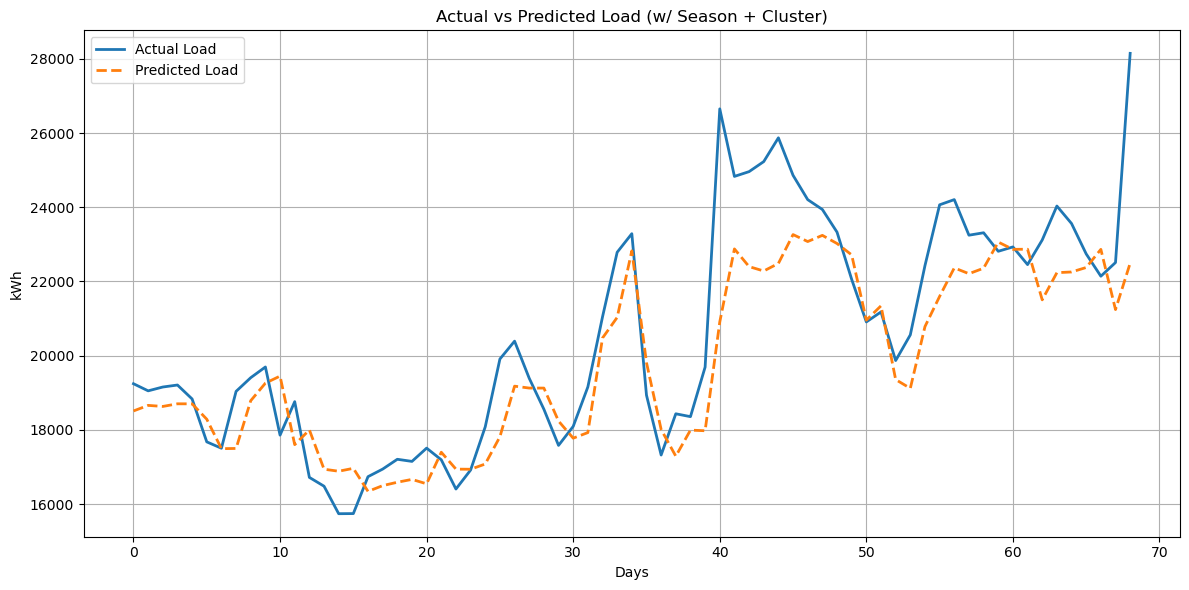

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Drop NaNs from lag/rolling
features_clean = features_df.dropna()

# ✅ Feature set including season and cluster
X = features_clean[[
    'day_of_week', 'is_weekend', 'lag_1', 'lag_7',
    'rolling_avg_7', 'rolling_std_7', 'season', 'cluster'
]]

# Encode categorical features
X = pd.get_dummies(X, columns=['is_weekend', 'season'], drop_first=True)

# Target
y = features_clean['total_load']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Load', linewidth=2)
plt.plot(y_pred, label='Predicted Load', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Load (w/ Season + Cluster)")
plt.xlabel("Days")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [63]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


XGBoost MAE: 1162.39
XGBoost RMSE: 1684.67


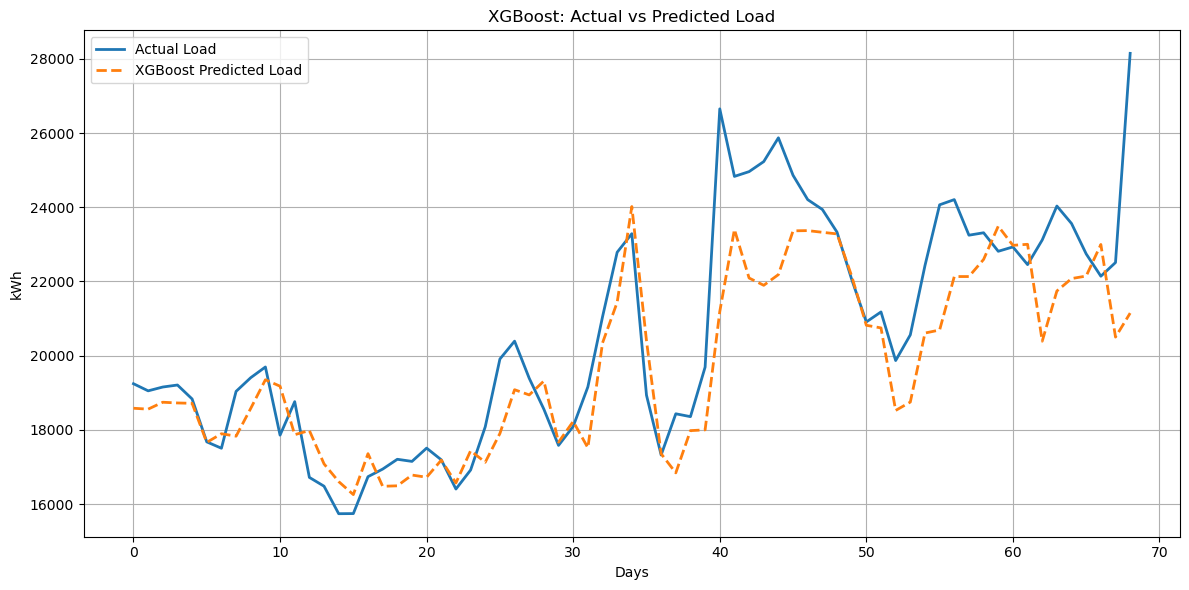

In [64]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Prepare features again (same as for RF)
features_clean = features_df.dropna()

X = features_clean[[
    'day_of_week', 'is_weekend', 'lag_1', 'lag_7',
    'rolling_avg_7', 'rolling_std_7', 'season', 'cluster'
]]

X = pd.get_dummies(X, columns=['is_weekend', 'season'], drop_first=True)
y = features_clean['total_load']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 🔁 Train XGBoost
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Load', linewidth=2)
plt.plot(y_pred, label='XGBoost Predicted Load', linestyle='--', linewidth=2)
plt.title("XGBoost: Actual vs Predicted Load")
plt.xlabel("Days")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


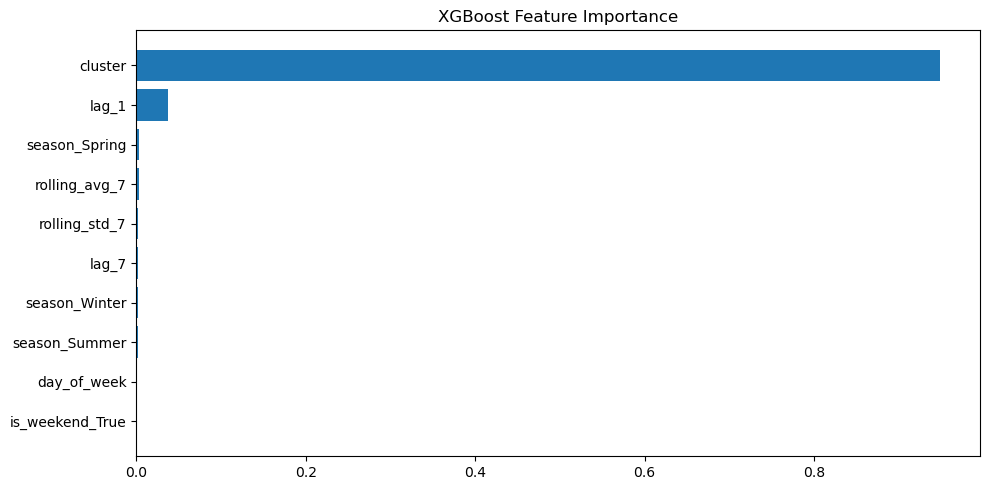

In [65]:
import matplotlib.pyplot as plt
xgb_importances = model.feature_importances_
sorted_idx = np.argsort(xgb_importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 5))
plt.barh(feature_names[sorted_idx], xgb_importances[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [66]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

# Reuse your cleaned X, y
features_clean = features_df.dropna()

X = features_clean[[
    'day_of_week', 'is_weekend', 'lag_1', 'lag_7',
    'rolling_avg_7', 'rolling_std_7', 'season', 'cluster'
]]
X = pd.get_dummies(X, columns=['is_weekend', 'season'], drop_first=True)
y = features_clean['total_load']

# Time-aware split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Parameters focused on best-performing zone
param_dist_refined = {
    'n_estimators': randint(80, 150),
    'max_depth': randint(4, 8),
    'learning_rate': uniform(0.05, 0.1),  # Narrowed around 0.1
    'subsample': uniform(0.7, 0.2),       # 0.7–0.9
    'colsample_bytree': uniform(0.7, 0.2) # 0.7–0.9
}
# Set up search
xgb_model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Predict & evaluate
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Tuned XGBoost MAE: {mae:.2f}")
print(f"Tuned XGBoost RMSE: {rmse:.2f}")



Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'colsample_bytree': 0.8404460046972835, 'learning_rate': 0.1516145155592091, 'max_depth': 8, 'n_estimators': 102, 'subsample': 0.9879639408647978}
Tuned XGBoost MAE: 1188.89
Tuned XGBoost RMSE: 1709.70


Final Model (Manual Params) MAE: 1154.92
Final Model (Manual Params) RMSE: 1639.45


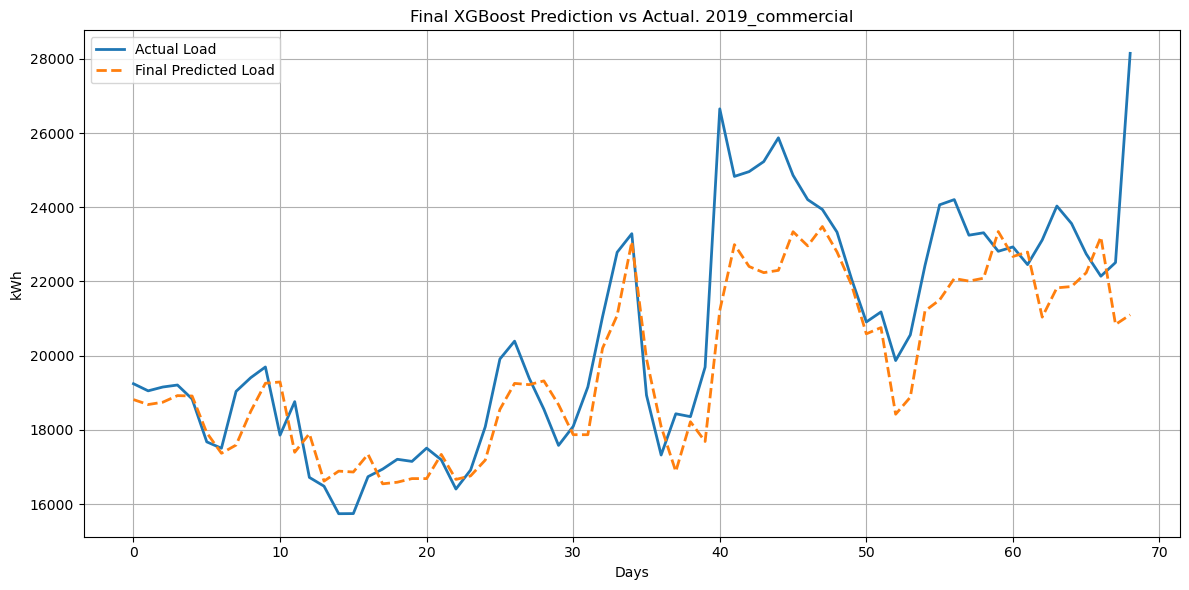

In [67]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Set final best parameters manually
final_model = XGBRegressor(
    n_estimators=120,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
final_model.fit(X_train, y_train)

# Predict
y_pred_final = final_model.predict(X_test)

# Evaluate
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f"Final Model (Manual Params) MAE: {mae_final:.2f}")
print(f"Final Model (Manual Params) RMSE: {rmse_final:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Load', linewidth=2)
plt.plot(y_pred_final, label='Final Predicted Load', linestyle='--', linewidth=2)
plt.title("Final XGBoost Prediction vs Actual. 2019_commercial")
plt.xlabel("Days")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


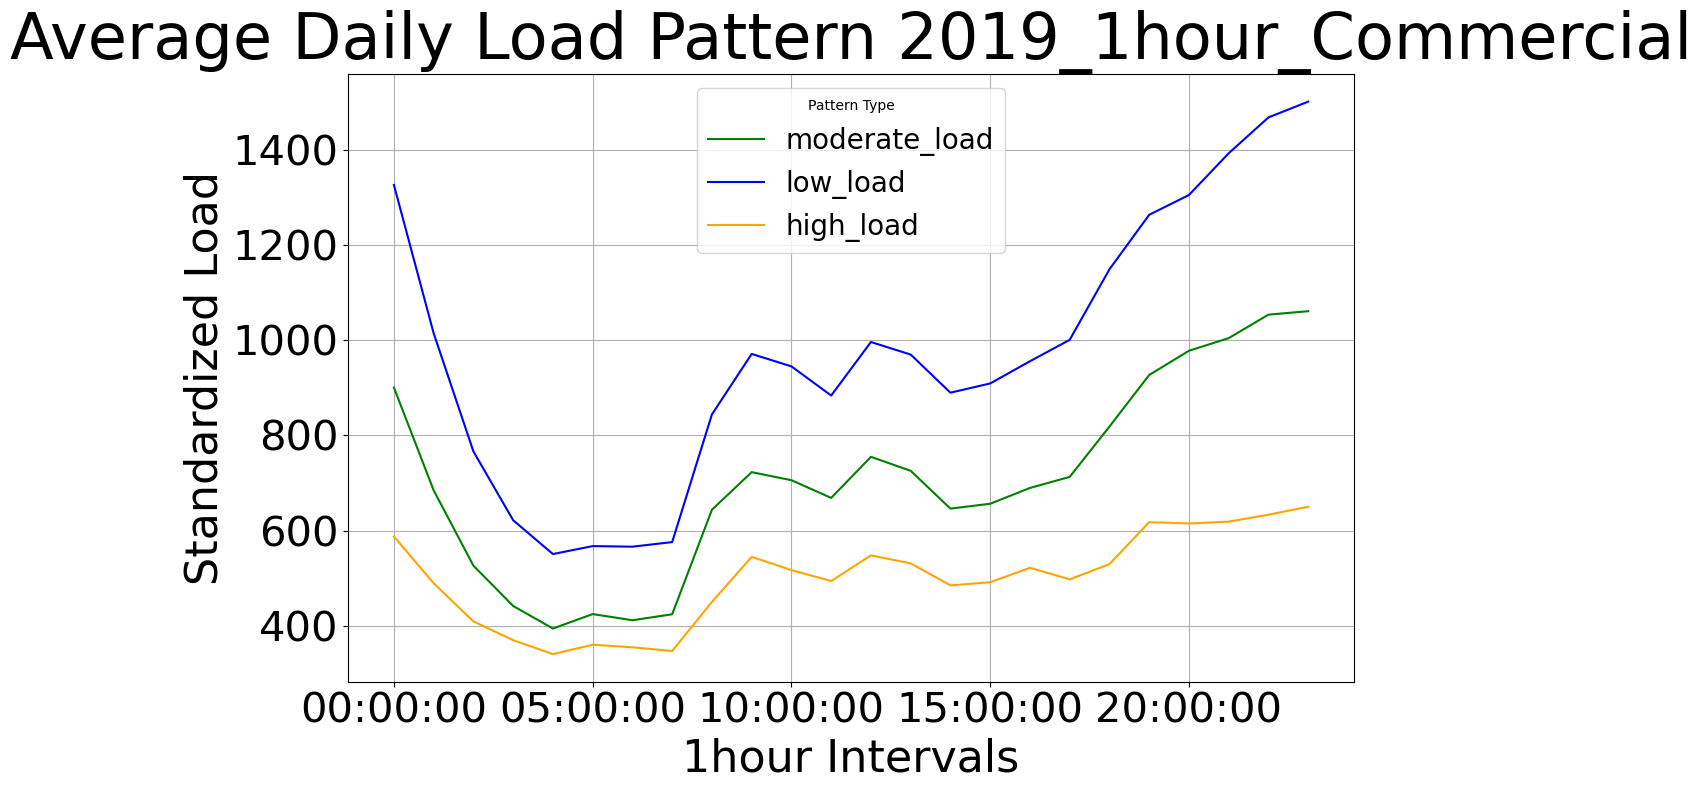

In [86]:
load_columns = pivot_df_interp.select_dtypes(include='number').columns.drop('cluster')

# Ensure clustering has been done and column exists
assert 'cluster' in pivot_df_interp.columns, "Missing 'cluster' column. Run KMeans first."

# Group by cluster, average the first 96 load columns
avg_by_label = pivot_df_interp.groupby("cluster")[load_columns].mean()

# Define custom labels
cluster_name_map = {
    0: "moderate_load",
    1: "low_load",
    2: "high_load"
}
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
# Rename cluster index to meaningful names
avg_by_label.index = avg_by_label.index.map(cluster_name_map)

color_map={
    "moderate_load":"green",
    "high_load":"orange",
    "low_load":"blue"
}
colors = [color_map.get(name, 'gray') for name in avg_by_label.index]

# Plot
avg_by_label.T.plot(figsize=(12, 8),color=colors)

plt.title("Average Daily Load Pattern 2019_1hour_Commercial", fontsize=46)
plt.xlabel("1hour Intervals", fontsize=32)
plt.ylabel("Standardized Load", fontsize=32)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(title="Pattern Type", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
cluster_name_map = {
    0: "moderate_load",
    1: "low_load",
    2: "high_load"
}
for c in sorted(pivot_df_interp['cluster'].unique()):
    name = cluster_name_map[c]
    print(f"\nCluster {c} ({name}):")
    dates = pivot_df_interp[pivot_df_interp['cluster'] == c]['date'].tolist()
    print(dates[:10])


Cluster 0 (moderate_load):
[Timestamp('2019-01-13 00:00:00'), Timestamp('2019-01-14 00:00:00'), Timestamp('2019-01-15 00:00:00'), Timestamp('2019-01-16 00:00:00'), Timestamp('2019-01-17 00:00:00'), Timestamp('2019-01-18 00:00:00'), Timestamp('2019-02-18 00:00:00'), Timestamp('2019-02-20 00:00:00'), Timestamp('2019-02-21 00:00:00'), Timestamp('2019-02-22 00:00:00')]

Cluster 1 (low_load):
[Timestamp('2019-01-01 00:00:00'), Timestamp('2019-01-02 00:00:00'), Timestamp('2019-01-03 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-01-05 00:00:00'), Timestamp('2019-01-06 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2019-01-08 00:00:00'), Timestamp('2019-01-09 00:00:00'), Timestamp('2019-01-10 00:00:00')]

Cluster 2 (high_load):
[Timestamp('2019-01-25 00:00:00'), Timestamp('2019-01-26 00:00:00'), Timestamp('2019-01-27 00:00:00'), Timestamp('2019-01-28 00:00:00'), Timestamp('2019-01-29 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-31 00:00:00'), Time

In [70]:
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels_2019_1hour_Commercial.csv")

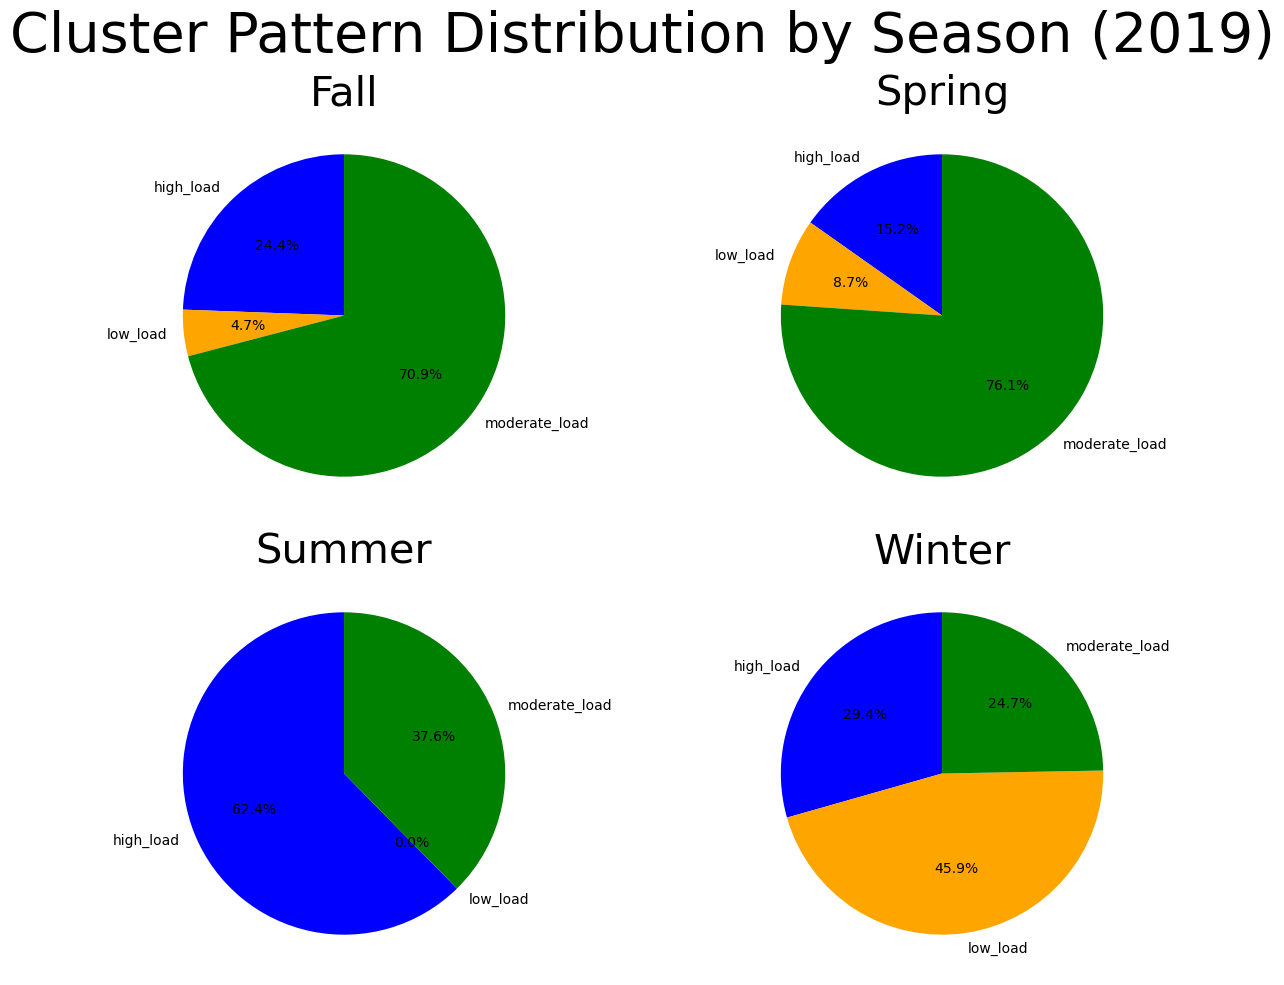

In [71]:
pivot_df_interp['date'] = pd.to_datetime(pivot_df_interp['date'])
pattern_by_season = pivot_df_interp.groupby(['season', 'pattern']).size().unstack(fill_value=0)

seasons = pattern_by_season.index.tolist()
labels = pattern_by_season.columns.tolist()

# Define color mapping
color_dict = {
    'low_load': 'orange',
    'high_load': 'blue',
    'moderate_load':'green'
}
# Assign default color if pattern not in the dictionary
colors = [color_dict.get(label, 'gray') for label in labels]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of pie charts

for i, season in enumerate(seasons):
    ax = axes[i // 2, i % 2]
    ax.pie(
        pattern_by_season.loc[season], 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=colors
    )
    ax.set_title(f"{season}",fontsize=30)

plt.suptitle("Cluster Pattern Distribution by Season (2019)",fontsize=40)
plt.tight_layout()
plt.show()

season
Summer    70876.546699
Spring    82246.484907
Fall      84266.910017
Winter    89608.276397
Name: total_load, dtype: float64


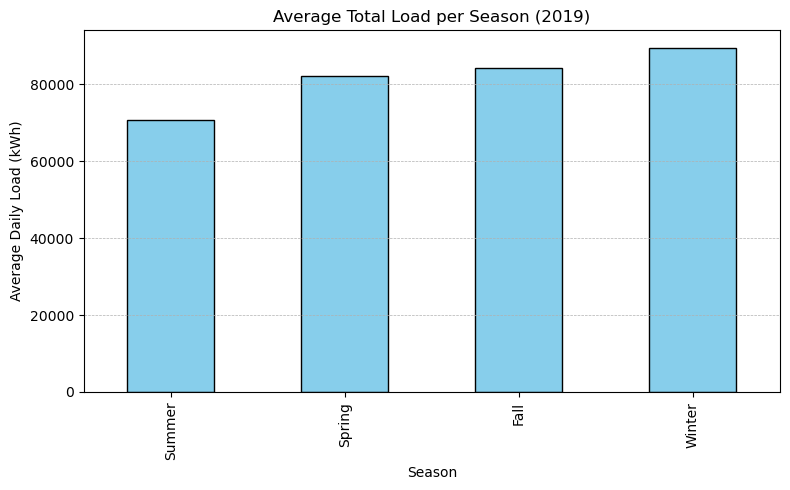

In [72]:
# 1. Assign season
pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)

# 2. Compute total load per day
load_columns = pivot_df_interp.select_dtypes(include='number').columns.drop('cluster', errors='ignore')  # safely drop cluster if exists
pivot_df_interp['total_load'] = pivot_df_interp[load_columns].sum(axis=1)

# 3. Compute seasonal average total load
season_avg = pivot_df_interp.groupby('season')['total_load'].mean().sort_values()
print(season_avg)

# 4. Optional: Visualize
season_avg.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(8,5))
plt.title("Average Total Load per Season (2019)")
plt.ylabel("Average Daily Load (kWh)")
plt.xlabel("Season")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


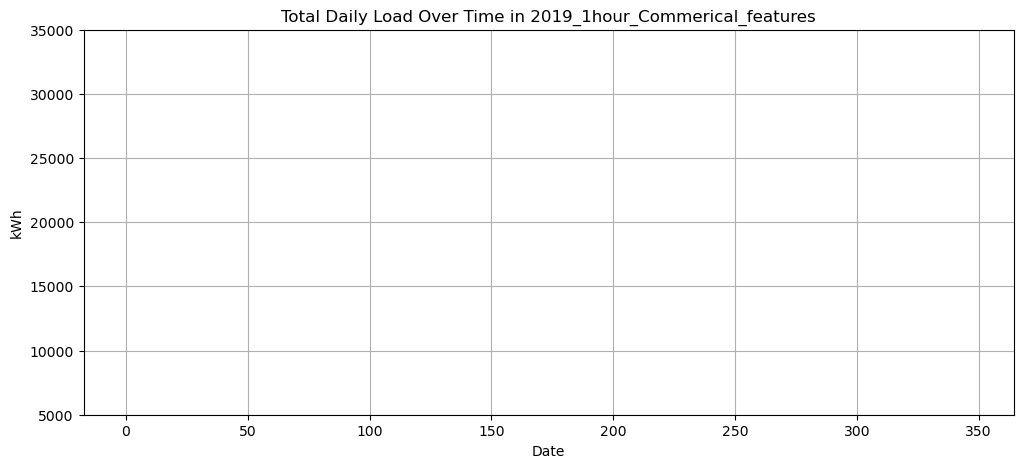

In [73]:
# 1. 完成所有预处理（插值、聚类、添加 pattern 和 season）
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)

# 2. 必须在这里清洗列名！所有后续都基于它！
pivot_df_interp.columns = pivot_df_interp.columns.map(str)

# 3. 抓负载列（非 date / cluster / pattern / season）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

# 4. 提取特征（注意 idxmax 前，列名必须是 string）
features_df = pd.DataFrame(index=pivot_df_interp.index)
features_df["total_load"] = pivot_df_interp[load_columns].sum(axis=1)
features_df["peak_load"] = pivot_df_interp[load_columns].max(axis=1)
features_df["valley_load"] = pivot_df_interp[load_columns].min(axis=1)
features_df["load_range"] = features_df["peak_load"] - features_df["valley_load"]
features_df["load_std"] = pivot_df_interp[load_columns].std(axis=1)
features_df["time_of_peak"] = pivot_df_interp[load_columns].idxmax(axis=1)
features_df["time_of_valley"] = pivot_df_interp[load_columns].idxmin(axis=1)

# 5.把时间截干净
features_df["time_of_peak"] = features_df["time_of_peak"].str[-8:]
features_df["time_of_valley"] = features_df["time_of_valley"].str[-8:]

# ✅ Plot with fixed y-axis range (5000–35000)
features_df["total_load"].plot(
    figsize=(12, 5),
    title="Total Daily Load Over Time in 2019_1hour_Commerical_features"
)
plt.xlabel("Date")
plt.ylabel("kWh")
plt.ylim(5000, 35000)  # <-- Set Y-axis limits here
plt.grid(True)
plt.show()

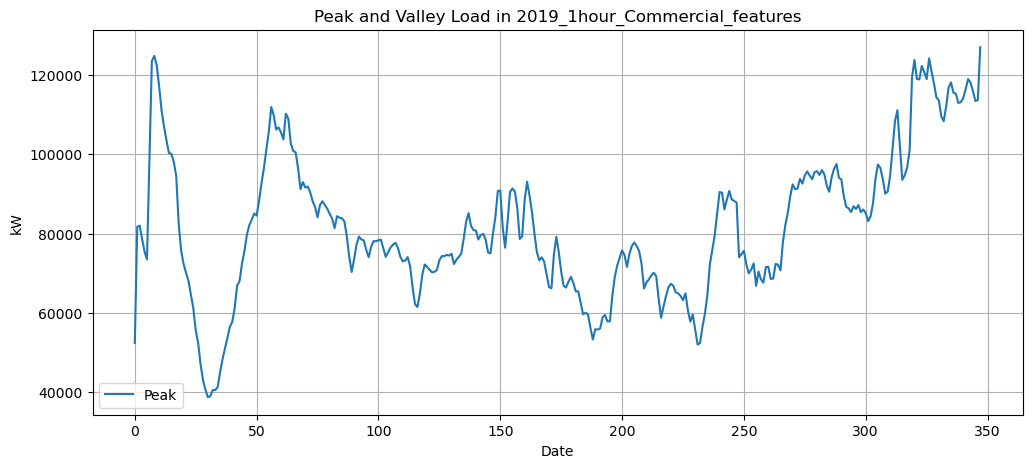

In [74]:
features_df[["peak_load", "valley_load"]].plot(figsize=(12, 5), title="Peak and Valley Load in 2019_1hour_Commercial_features")
plt.xlabel("Date")
plt.ylabel("kW")
plt.legend(["Peak", "Valley"])
plt.grid(True)
plt.show()

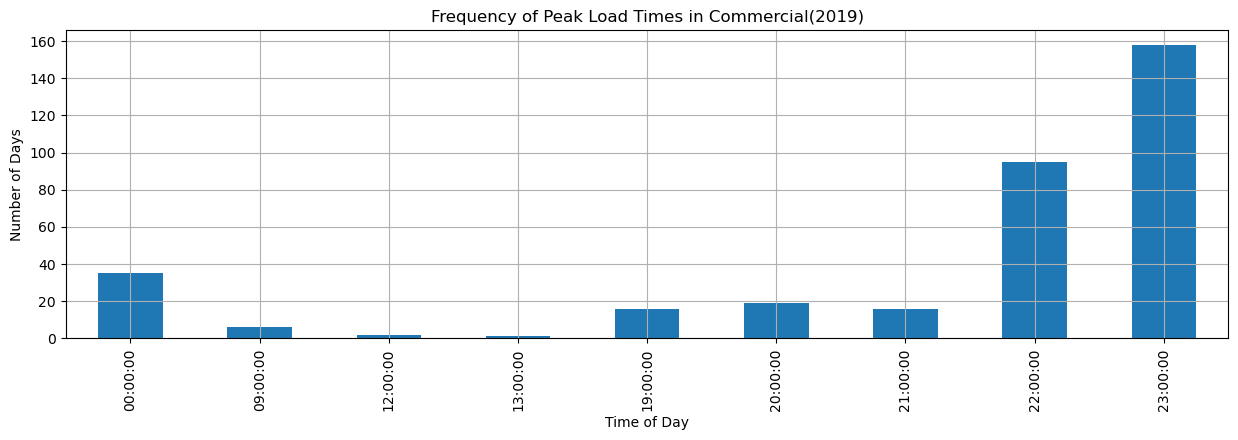

In [15]:
features_df["time_of_peak"].value_counts().sort_index().plot(kind="bar", figsize=(15, 4), title="Frequency of Peak Load Times in Commercial(2019)")
plt.xlabel("Time of Day")
plt.ylabel("Number of Days")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

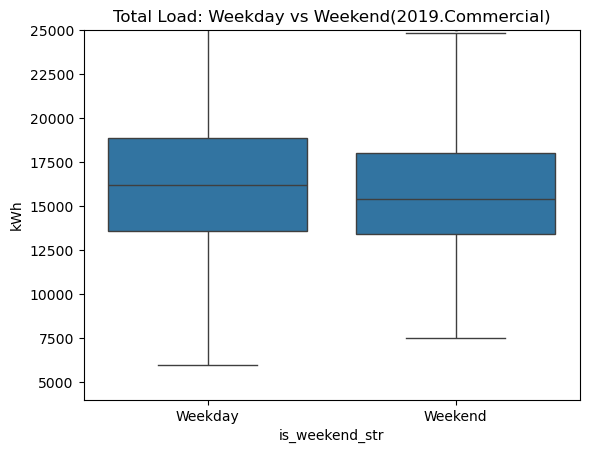

In [16]:
features_df['is_weekend'] = pivot_df_interp['date'].dt.weekday >= 5
features_df['is_weekend_str'] = features_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
features_df["is_weekend_str"] = features_df["is_weekend"].map({True: "Weekend", False: "Weekday"})
sns.boxplot(x="is_weekend_str", y="total_load", data=features_df)
plt.title("Total Load: Weekday vs Weekend(2019.Commercial)")
plt.ylabel("kWh")
plt.ylim(4000, 25000)
plt.show()

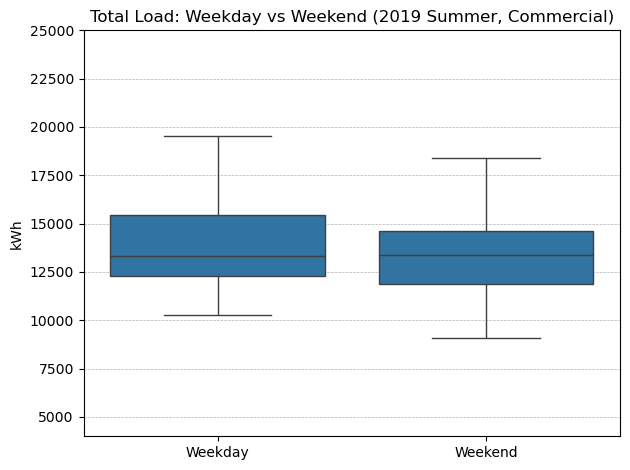

In [23]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

features_df['season'] = pivot_df_interp['date'].apply(get_season)

summer_df = features_df[features_df['season'] == 'Summer']
sns.boxplot(
    x="is_weekend_str",
    y="total_load",
    data=summer_df,
    order=["Weekday", "Weekend"]  # 🔁 Force this order!
)

plt.title("Total Load: Weekday vs Weekend (2019 Summer, Commercial)")
plt.ylabel("kWh")
plt.xlabel("")  # Optional
plt.ylim(4000, 25000)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

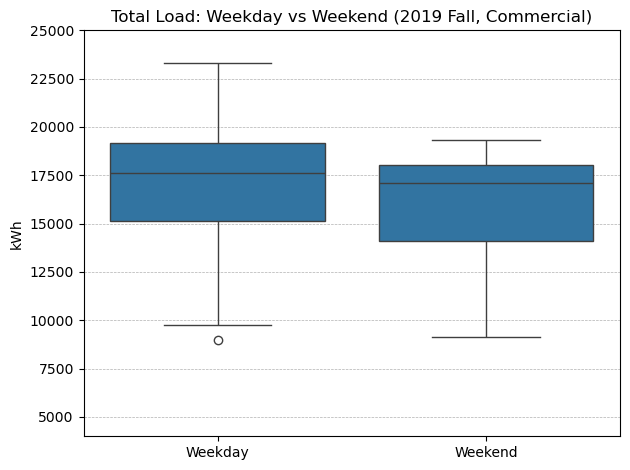

In [26]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

features_df['season'] = pivot_df_interp['date'].apply(get_season)

Fall_df = features_df[features_df['season'] == 'Fall']

sns.boxplot(
    x="is_weekend_str",
    y="total_load",
    data=Fall_df,
    order=["Weekday", "Weekend"]  # 🔁 Force this order!
)

plt.title("Total Load: Weekday vs Weekend (2019 Fall, Commercial)")
plt.ylabel("kWh")
plt.xlabel("")  # Optional
plt.ylim(4000, 25000)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

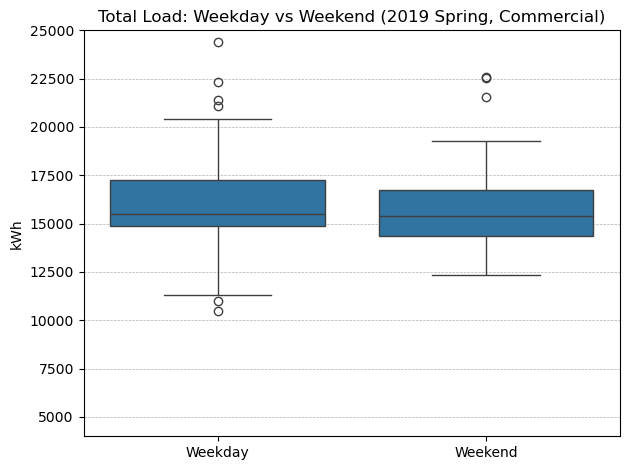

In [27]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

features_df['season'] = pivot_df_interp['date'].apply(get_season)

Spring_df = features_df[features_df['season'] == 'Spring']

sns.boxplot(
    x="is_weekend_str",
    y="total_load",
    data=Spring_df,
    order=["Weekday", "Weekend"]  # 🔁 Force this order!
)

plt.title("Total Load: Weekday vs Weekend (2019 Spring, Commercial)")
plt.ylabel("kWh")
plt.xlabel("")  # Optional
plt.ylim(4000, 25000)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

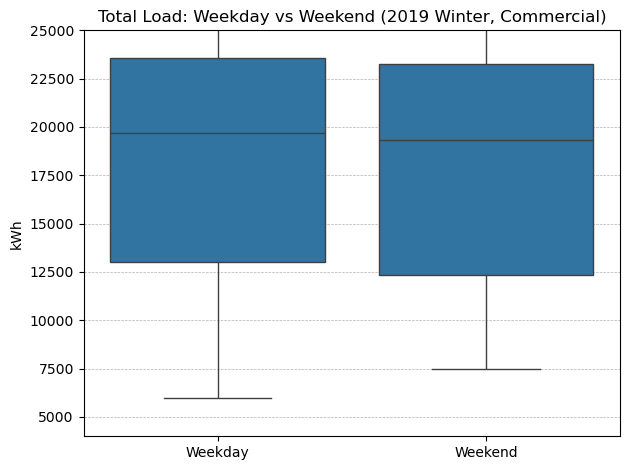

In [29]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

features_df['season'] = pivot_df_interp['date'].apply(get_season)

Winter_df = features_df[features_df['season'] == 'Winter']

sns.boxplot(
    x="is_weekend_str",
    y="total_load",
    data=Winter_df,
    order=["Weekday", "Weekend"]  # 🔁 Force this order!
)

plt.title("Total Load: Weekday vs Weekend (2019 Winter, Commercial)")
plt.ylabel("kWh")
plt.xlabel("")  # Optional
plt.ylim(4000, 25000)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

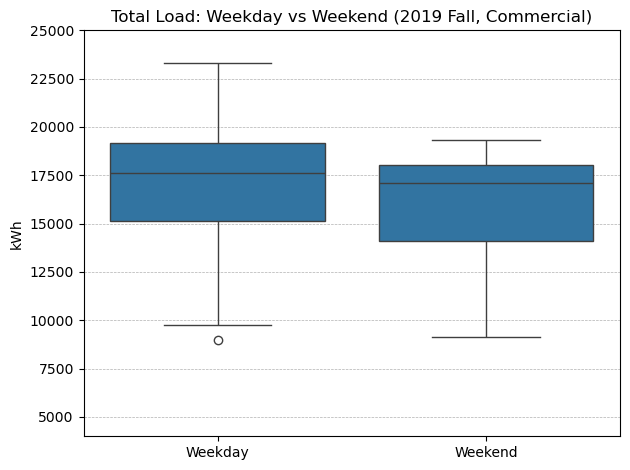

In [30]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

features_df['season'] = pivot_df_interp['date'].apply(get_season)

Fall_df = features_df[features_df['season'] == 'Fall']

sns.boxplot(
    x="is_weekend_str",
    y="total_load",
    data=Fall_df,
    order=["Weekday", "Weekend"]  # 🔁 Force this order!
)

plt.title("Total Load: Weekday vs Weekend (2019 Fall, Commercial)")
plt.ylabel("kWh")
plt.xlabel("")  # Optional
plt.ylim(4000, 25000)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

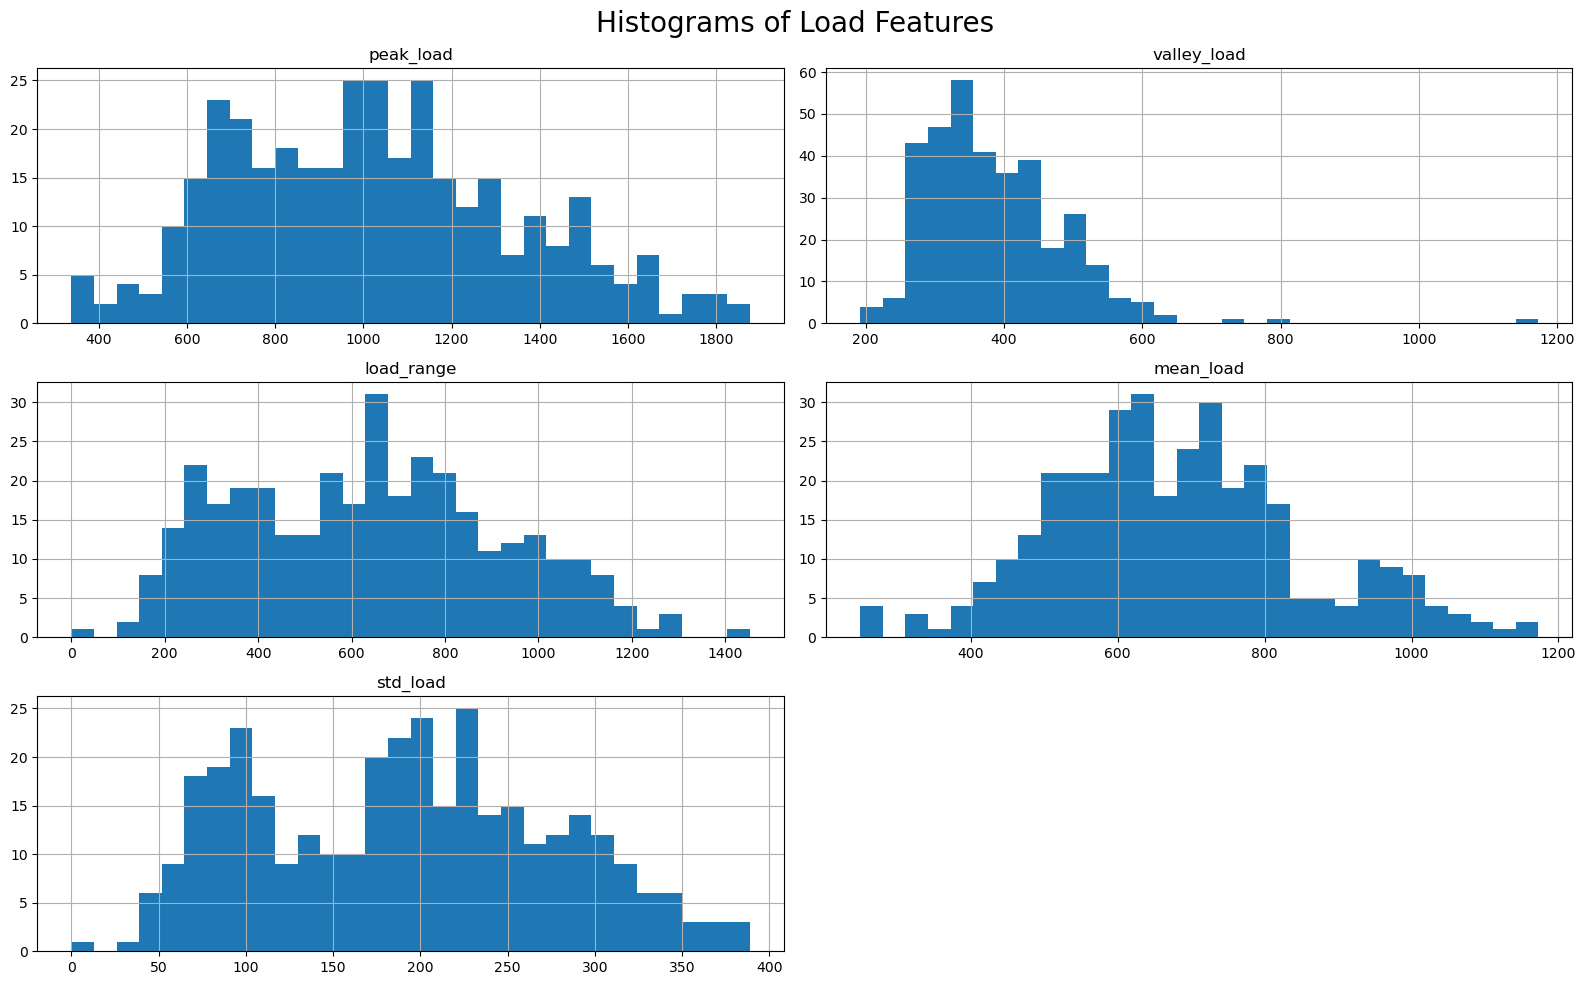

In [17]:
feature_df = pd.DataFrame(index=pivot_df_interp.index)

# 选择中间的负载列（避开 date, cluster 等）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

feature_df['peak_load'] = pivot_df_interp[load_columns].max(axis=1)
feature_df['valley_load'] = pivot_df_interp[load_columns].min(axis=1)
feature_df['load_range'] = feature_df['peak_load'] - feature_df['valley_load']
feature_df['mean_load'] = pivot_df_interp[load_columns].mean(axis=1)
feature_df['std_load'] = pivot_df_interp[load_columns].std(axis=1)
feature_df['load_factor'] = feature_df['mean_load'] / feature_df['peak_load']
feature_df['peak_time'] = pivot_df_interp[load_columns].idxmax(axis=1)
feature_df['valley_time'] = pivot_df_interp[load_columns].idxmin(axis=1)
plt.figure(figsize=(16, 10))
feature_df[['peak_load', 'valley_load', 'load_range', 'mean_load', 'std_load']].hist(bins=30, figsize=(16, 10))
plt.suptitle("Histograms of Load Features", fontsize=20)
plt.tight_layout()
plt.show()